In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import csv
from matplotlib.ticker import FuncFormatter
import os
from utils import *

BASE_DATA_PATH = os.path.join("..", "out", "clouds")
OUTPUT_FOLDER = os.path.join("..", "out", "figures", "cloud")
set_default_style(font_size = 14, axes_labelsize= 16, xtick_labelsize=12, ytick_labelsize=10, legend_fontsize=9, legend_title_fontsize=14)


In [8]:
def plot_octree_bounds(ax, bounds_file, max_level, line_width=0.25, color='black',):
    with open(bounds_file, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            level = int(row[0])
            if level <= max_level:
                upx, upy, upz = float(row[1]), float(row[2]), float(row[3])
                downx, downy, downz = float(row[4]), float(row[5]), float(row[6])
                corners = np.array([
                    [downx, downy, downz],
                    [upx,   downy, downz],
                    [upx,   upy,   downz],
                    [downx, upy,   downz],
                    [downx, downy, upz],
                    [upx,   downy, upz],
                    [upx,   upy,   upz],
                    [downx, upy,   upz]
                ])
                edges = [
                    (0, 1), (1, 2), (2, 3), (3, 0),  # bottom face
                    (4, 5), (5, 6), (6, 7), (7, 4),  # top face
                    (0, 4), (1, 5), (2, 6), (3, 7)   # vertical edges
                ]
                for edge in edges:
                    p1 = corners[edge[0]]
                    p2 = corners[edge[1]]
                    line, = ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]],
                                    color=color, linewidth=0.4/(level+1), alpha=0.3)
                    line.set_rasterized(True) 
                    
def plot_cloud(data_folder, cloud, max_points,
                            draw_line=False, line_width=0.25, point_width=2,
                            octree_file=None, max_bound_level=None,
                            bounds_line_width=0.25, bounds_color='black', remove_decorations = False, 
                            uncolored = False):
    points = read_points(data_folder, cloud)
    num_points = len(points)

    if num_points > max_points:
        indices = np.linspace(0, num_points - 1, max_points, dtype=int)
    else:
        indices = np.arange(num_points)
    
    sampled_points = points[indices]
    
    norm = Normalize(vmin=0, vmax=num_points)
    if uncolored:
        # Assigns a consistent gray color to every point
        colors = ['gray' for _ in indices]
    else:
        # Uses the viridis colormap based on indices
        cmap = cm.get_cmap('viridis')
        colors = [cmap(norm(i)) for i in indices]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    

    # Plot line segments between points if requested
    if draw_line:
        print("Drawing line segments...")
        for i in range(len(sampled_points) - 1):
            line, = ax.plot([sampled_points[i, 0], sampled_points[i+1, 0]], 
                    [sampled_points[i, 1], sampled_points[i+1, 1]], 
                    [sampled_points[i, 2], sampled_points[i+1, 2]], 
                    c=colors[i], linewidth=line_width)
            line.set_rasterized(True)
    
    # Plot octree bounds if provided
    if octree_file is not None and max_bound_level is not None:
        print("Drawing octree bounds...")
        plot_octree_bounds(ax, octree_file, max_bound_level, 
                           line_width=bounds_line_width, color=bounds_color)
    # Plot the points
    print("Drawing points...")
    ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], 
                         c=colors, marker='o', s=point_width, zorder = 2, rasterized= True)

    if not uncolored:
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
    custom_ticks = [
        0,
        int(num_points * 0.25),
        int(num_points * 0.5),
        int(num_points * 0.75),
        int(num_points)
    ]

    def no_decimal_format(x, pos):
        return f'{int(x)}'
    
    if not remove_decorations:
        if not uncolored:
            cbar = fig.colorbar(sm, ax=ax, aspect=20, pad=0.1, ticks=custom_ticks, shrink=0.8)
            cbar.ax.yaxis.set_major_formatter(FuncFormatter(no_decimal_format))
            cbar.ax.xaxis.set_label_position('top')
            fig.text(0.867, 0.935, "Index", ha='center', va='top', fontsize=12, color='black')
        
        x_min, y_min, z_min = np.min(sampled_points, axis=0)
        x_max, y_max, z_max = np.max(sampled_points, axis=0)
        x_mid, y_mid, z_mid = (x_min + x_max) / 2, (y_min + y_max) / 2, (z_min + z_max) / 2
        ax.set_xticks([x_min, x_mid, x_max])
        ax.set_yticks([y_min, y_mid, y_max])
        ax.set_zticks([z_min, z_mid, z_max])
        ax.xaxis.set_major_formatter(FuncFormatter(no_decimal_format))
        ax.yaxis.set_major_formatter(FuncFormatter(no_decimal_format))
        ax.zaxis.set_major_formatter(FuncFormatter(no_decimal_format))
        ax.xaxis.set_tick_params(labelsize=10)
        ax.yaxis.set_tick_params(labelsize=10)
        ax.zaxis.set_tick_params(labelsize=10)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
    else:
        ax.set_axis_off()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_zlabel('')
        
        ax.grid(False)
        ax.xaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))

        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

    plt.tight_layout()
    return fig

/tmp/ipykernel_2711502/3948084721.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


Drawing points...


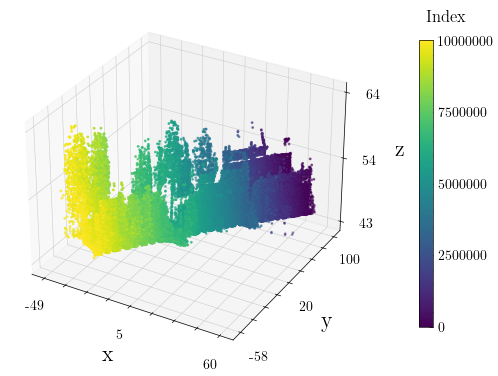

In [9]:
CLOUD = "lille_0_unencoded"
fig = plot_cloud(BASE_DATA_PATH, CLOUD, 100000, draw_line = False, point_width=1)
output_fig(fig, OUTPUT_FOLDER, f'plot_{CLOUD}')
fig

/tmp/ipykernel_2711502/3948084721.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


Drawing points...


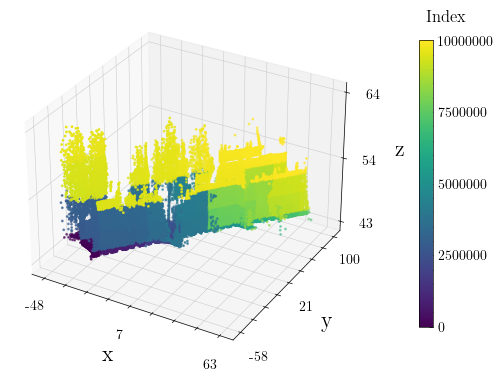

In [10]:
CLOUD = "lille_0_morton"
fig = plot_cloud(BASE_DATA_PATH, CLOUD, 100000, draw_line = False, point_width=1)
output_fig(fig, OUTPUT_FOLDER, f'plot_{CLOUD}')
fig

/tmp/ipykernel_2711502/3948084721.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


Drawing points...


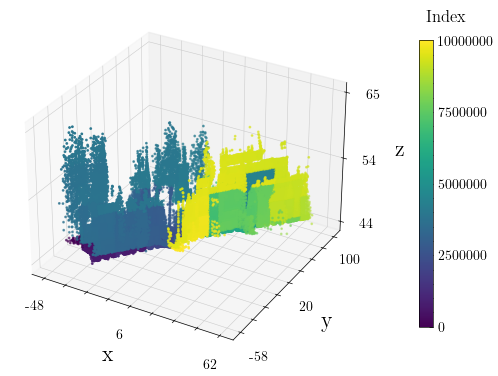

In [11]:
CLOUD = "lille_0_hilbert"
fig = plot_cloud(BASE_DATA_PATH, CLOUD, 100000, draw_line = False, point_width=1)
output_fig(fig, OUTPUT_FOLDER, f'plot_{CLOUD}')
fig

/tmp/ipykernel_9284/804386775.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


Drawing octree bounds...
Drawing points...


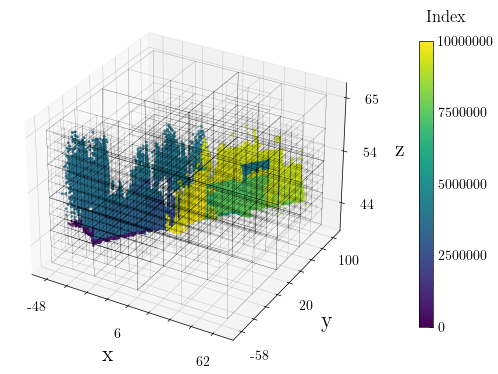

In [4]:
CLOUD = "lille_0_hilbert"
octree_file = os.path.join(BASE_DATA_PATH, f'lille_0_hilbert_oct.csv')
fig = plot_cloud(BASE_DATA_PATH, CLOUD, 100000, draw_line = False, octree_file=octree_file, point_width=1, max_bound_level=4)
output_fig(fig, OUTPUT_FOLDER, f'plot_{CLOUD}_oct')
fig

Drawing octree bounds...
Drawing points...


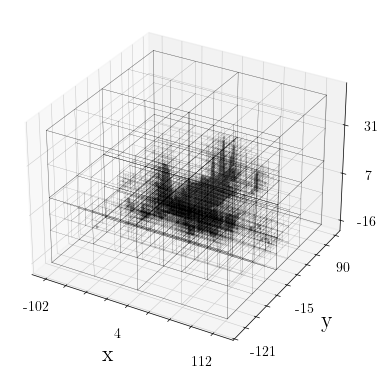

In [9]:
CLOUD = "bildstein_station1_morton"
octree_file = os.path.join(BASE_DATA_PATH, f'bildstein_station1_morton_oct.csv')
fig = plot_cloud(BASE_DATA_PATH, CLOUD, 100000, draw_line = False, octree_file=octree_file, point_width=1, max_bound_level=5, uncolored=True)
output_fig(fig, OUTPUT_FOLDER, f'plot_{CLOUD}_oct')
fig